## **Sentiment Analysis - NLP Project**

 **Using Amazon reviews dataset in order to train our model**

 Motahareh Hojabr Yousefi - Summer 2023

## **Part 1 - Sentiment analysis using Logistic Regression**

libraries used for this part:

In [33]:
from io import StringIO
import requests
import html
import time
import sys
import h5py
import io
import pandas as pd
import numpy as np
import nltk
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')
from nltk.corpus import stopwords as sw
import string
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Uploaded raw .tsv file in G Drive, using it with the *pandas* lib. The only relevant categories are 'star rating', 'review headline' and 'review body'.

### Making the dataset

In [17]:

from google.colab import drive

drive.mount('/content/drive',  force_remount=True)
df = pd.read_csv("/content/drive/My Drive/nlpProject-990122680013/amazon_alexa.tsv",delimiter='\t',on_bad_lines='skip')
df.verified_reviews = df.verified_reviews.astype(str)
review_df = df[['rating','verified_reviews']]
print(review_df.shape)
review_df.head(5)

Mounted at /content/drive
(3150, 2)


,rating,verified_reviews
0,5,Love my Echo!
1,5,Loved it!
2,4,"Sometimes while playing a game, you can answer..."
3,5,I have had a lot of fun with this thing. My 4 ...
4,5,Music


using value.counts() to count the no. of star ratings for each rating. defining a new column for positive or negative values, then defining a value where every star rating above 3 is counted as positive, otherwise negative.

In [18]:
df.loc[df.rating.isin([1,2,3]), 'pos_neg'] = 'negative'
df.loc[df.rating.isin([4,5]), 'pos_neg'] = 'positive'
review_df["rating"].value_counts()

,count
rating,
5,2286
4,455
1,161
3,152
2,96


Only relevant data needed is the pos_neg and review_body columns. then we choose some random reviews for faster processing.

In [24]:
data = df[['pos_neg', 'verified_reviews']]
min_samples = data['pos_neg'].value_counts().min()
n_samples = min(min_samples, 1000)
sample = data.groupby("pos_neg").sample(n=n_samples)
display(sample)

,pos_neg,verified_reviews
2047,negative,I will be returning this piece of garbage as s...
1450,negative,Thought it would be more powerful and have a l...
558,negative,Stopped working after 7 months. The warranty w...
2970,negative,Alexa is pretty basic and almost like a toy. S...
1764,negative,
...,...,...
1777,positive,"Awesome product, very responsive!Alexa just ne..."
439,positive,Love it just as good as a new one
555,positive,I purchased this refurbished. Works just like...
47,positive,Love my Echo. Still learning how every thing w...


### Preprocessing
normalizing, tokenizing, negation handling and processing text. using bigram and trigram models.

In [25]:
lemmatizer = nltk.WordNetLemmatizer()
stopwords = sw.words('english')
stopwords = stopwords + ['not_' + w for w in stopwords]
trans_punct = str.maketrans(string.punctuation,' '*len(string.punctuation))
pad_punct = str.maketrans({key: " {0} ".format(key) for key in string.punctuation})
invalidChars = str(string.punctuation.replace("_", ""))
def preprocessing(line, ngram=1, neg_handling=True, remove_stop=False):

    line = html.unescape(str(line))
    line = str(line).replace("can't", "can not")
    line = str(line).replace("n't", " not")

    if neg_handling:
        line = str(line).translate(pad_punct)  #negation handling
        line = nltk.word_tokenize(line.lower()) # normalization, tokenization
        tokens = []
        negated = False
        for t in line:
            if t in ['not', 'no']:
                negated = not negated
            elif t in string.punctuation or not t.isalpha():
                negated = False
            else:
                tokens.append('not_' + t if negated else t)
    else:
        line = str(line).translate(trans_punct)
        line = nltk.word_tokenize(line.lower())
        tokens = line

    if ngram == 2:
        bi_tokens = list(nltk.bigrams(line))
        bi_tokens = list(map('_'.join, bi_tokens))
        bi_tokens = [i for i in bi_tokens if all(j not in invalidChars for j in i)]
        tokens = tokens + bi_tokens

    if ngram == 3:
        bi_tokens = list(nltk.bigrams(line))
        bi_tokens = list(map('_'.join, bi_tokens))
        bi_tokens = [i for i in bi_tokens if all(j not in invalidChars for j in i)]
        tri_tokens = list(nltk.trigrams(line))
        tri_tokens = list(map('_'.join, tri_tokens))
        tri_tokens = [i for i in tri_tokens if all(j not in invalidChars for j in i)]
        tokens = tokens + bi_tokens + tri_tokens

    if remove_stop:
        line = [lemmatizer.lemmatize(t) for t in tokens if t not in stopwords]
    else:
        line = [lemmatizer.lemmatize(t) for t in tokens]

    return ' '.join(line)

balancing the dataset:

In [26]:
neg = sample.loc[sample.pos_neg == 'negative']
pos = sample.loc[sample.pos_neg == 'positive'].sample(n = sample.pos_neg.value_counts()['negative'], random_state = 42)

defining a funtion to print iterations progress. nothing serious,just to make it more visible :)

In [27]:
def print_progress(iteration, total, prefix = '', suffix = '', decimals = 1, bar_length = 30):

    str_format = "{0:." + str(decimals) + "f}"
    percents = str_format.format(100 * (iteration / float(total)))
    filled_length = int(round(bar_length * iteration / float(total)))
    if filled_length == 0 or filled_length == bar_length:
        bar = '=' * filled_length + '.' * (bar_length - filled_length)
    else:
        bar = '=' * (filled_length - 1) + '>' + '.' * (bar_length - filled_length)
    sys.stdout.write('\r%s |%s| %s%s %s' % (prefix, bar, percents, '%', suffix)),
    if iteration == total:
        sys.stdout.write('\n')
    sys.stdout.flush()

preprocessing positive reviews:

In [34]:
pos_data = []
n_pos = len(pos)
for i, p in enumerate(pos['verified_reviews']):
    pos_data.append(preprocessing(p, ngram = 3))
    print_progress(bar_length = 30, decimals = 1, iteration = i+1, total = n_pos, prefix = 'Preprocessing positive data: ')

Preprocessing positive data:  |==============================| 100.0% 


preprocessing negative reviews:

In [36]:
neg_data = []
n_neg = len(neg)
for i, n in enumerate(neg['verified_reviews']):
    neg_data.append(preprocessing(n, ngram = 3))
    print_progress(bar_length = 30, decimals = 1, iteration = i+1, total = n_neg, prefix ='Preprocessing negative data: ')

Preprocessing negative data:  |==============================| 100.0% 


now we combine pos and neg data:

In [39]:
data = pos_data + neg_data
labels = np.concatenate((pos['pos_neg'].values, neg['pos_neg'].values))
labels

array(['positive', 'positive', 'positive', 'positive', 'positive',
       'positive', 'positive', 'positive', 'positive', 'positive',
       'positive', 'positive', 'positive', 'positive', 'positive',
       'positive', 'positive', 'positive', 'positive', 'positive',
       'positive', 'positive', 'positive', 'positive', 'positive',
       'positive', 'positive', 'positive', 'positive', 'positive',
       'positive', 'positive', 'positive', 'positive', 'positive',
       'positive', 'positive', 'positive', 'positive', 'positive',
       'positive', 'positive', 'positive', 'positive', 'positive',
       'positive', 'positive', 'positive', 'positive', 'positive',
       'positive', 'positive', 'positive', 'positive', 'positive',
       'positive', 'positive', 'positive', 'positive', 'positive',
       'positive', 'positive', 'positive', 'positive', 'positive',
       'positive', 'positive', 'positive', 'positive', 'positive',
       'positive', 'positive', 'positive', 'positive', 'positi

### Training and testing the dataset

 training set, validation set, and testing set are 60%, 20%, and 20%.

In [40]:
train_data, rest_data, train_labels, rest_labels = train_test_split(data, labels, test_size = 0.4, stratify=labels, random_state = 42)
valid_data, test_data, valid_labels, test_labels = train_test_split(rest_data, rest_labels, test_size = 0.5, stratify=rest_labels, random_state = 42)
#checking the proportion just in case: 60 20 20
print("training size: ", len(train_data), "validation size: ", len(valid_data), "testing size: ", len(test_data))

training size:  490 validation size:  164 testing size:  164


now we use the bag of words technique, normalizing and computing the frequency of words, and printing the 10 most used words for reference:

In [41]:
tokens = [word for line in train_data for word in nltk.word_tokenize(line)]
word_features = nltk.FreqDist(tokens)
print(word_features)
word_features.most_common(10)

<FreqDist with 20934 samples and 43561 outcomes>


[('’', 638),
 ('the', 631),
 ('i', 588),
 ('it', 496),
 ('to', 482),
 ('and', 376),
 ('a', 374),
 ('is', 249),
 ('for', 191),
 ('my', 184)]

Removing words which occur only once, and vectorization (tf/idf):

In [42]:
topwords = [fpair[0] for fpair in list(word_features.most_common(len(word_features))) if fpair[1] >= 2]
len(topwords)
tf_vec = TfidfVectorizer()
tf_vec.fit_transform([' '.join(topwords)])
train_features = tf_vec.transform(train_data)
train_features.shape
test_features = tf_vec.transform(test_data)
test_features.shape

(164, 4382)

Using Logistic regression model, we print accuracy, recall and f1 score based on the training set.




In [43]:
logreg_model = LogisticRegression(max_iter = 200000)
print(logreg_model, end='\n'*2)
logreg_model.fit(train_features, train_labels)
logreg_pred = logreg_model.predict(test_features)
print('Accuracy = %.5f' % metrics.accuracy_score(test_labels, logreg_pred))
print(metrics.classification_report(y_pred = logreg_pred, y_true = test_labels, digits = 3))

LogisticRegression(max_iter=200000)

Accuracy = 0.84756
              precision    recall  f1-score   support

    negative      0.782     0.963     0.863        82
    positive      0.952     0.732     0.828        82

    accuracy                          0.848       164
   macro avg      0.867     0.848     0.845       164
weighted avg      0.867     0.848     0.845       164



Fine-tuning the features:

In [44]:
def train_with_n_topwords(n, tfidf = True, valid = True, alpha = 1.0):
    """
    Training the dataset using selected model and settings
    @params:
        n                       - Required: the number of features used to train the model (Int)
        tfidf                  - Optional: whether to perform the tfidf transformation (Boolean)
        valid                 - Optional: whether to use the validation set or the test set (Boolean)
        alpha                - Optional: the penalty parameter in the training model (Float)
    """
    topwords = [fpair[0] for fpair in list(word_features.most_common(n))]
    if tfidf:
        vec = TfidfVectorizer()
    else:
        vec = CountVectorizer()
    vec.fit_transform([' '.join(topwords)])
    model = LogisticRegression(solver = 'lbfgs', max_iter = 200000, C = alpha)

    train_X = vec.transform(train_data)
    model.fit(train_X, train_labels)

    if valid:
        valid_X = vec.transform(valid_data)
        pred = model.predict(valid_X)
        metr = metrics.accuracy_score(valid_labels, pred)
    else:
        test_X = vec.transform(test_data)
        pred = model.predict(test_X)
        metr = metrics.accuracy_score(test_labels, pred)

    print("N of topwords:", n, "alpha:", alpha, "accuracy:", metr)
    return metr, vec, model

training our model with stopwords (better results for higer range of i and alpha):

In [45]:
possible_n = [100000 * i for i in range(1, 6)]

logreg_tfidf_accuracies = []

for i, n in enumerate(possible_n):
    metr = train_with_n_topwords(n)[0]
    logreg_tfidf_accuracies.append([n, metr])

N of topwords: 100000 alpha: 1.0 accuracy: 0.8414634146341463
N of topwords: 200000 alpha: 1.0 accuracy: 0.8414634146341463
N of topwords: 300000 alpha: 1.0 accuracy: 0.8414634146341463
N of topwords: 400000 alpha: 1.0 accuracy: 0.8414634146341463
N of topwords: 500000 alpha: 1.0 accuracy: 0.8414634146341463


performing grid search on our LG model for better accuracy

In [46]:
logreg_grid_tfidf_accuracies = []

for n in [100000 * i for i in range(1, 6)]:
    for alpha in [0.1 * j for j in range(1, 6)]:
        metr = train_with_n_topwords(n, alpha = alpha)[0]
        logreg_grid_tfidf_accuracies.append([n, alpha, metr])
        logreg_grid_accu = pd.DataFrame(logreg_grid_tfidf_accuracies, columns = ['topwords', 'C', 'accuracy'])
logreg_grid_accu[logreg_grid_accu.accuracy == max(logreg_grid_accu.accuracy)]

N of topwords: 100000 alpha: 0.1 accuracy: 0.7317073170731707
N of topwords: 100000 alpha: 0.2 accuracy: 0.7317073170731707
N of topwords: 100000 alpha: 0.30000000000000004 accuracy: 0.7378048780487805
N of topwords: 100000 alpha: 0.4 accuracy: 0.8170731707317073
N of topwords: 100000 alpha: 0.5 accuracy: 0.823170731707317
N of topwords: 200000 alpha: 0.1 accuracy: 0.7317073170731707
N of topwords: 200000 alpha: 0.2 accuracy: 0.7317073170731707
N of topwords: 200000 alpha: 0.30000000000000004 accuracy: 0.7378048780487805
N of topwords: 200000 alpha: 0.4 accuracy: 0.8170731707317073
N of topwords: 200000 alpha: 0.5 accuracy: 0.823170731707317
N of topwords: 300000 alpha: 0.1 accuracy: 0.7317073170731707
N of topwords: 300000 alpha: 0.2 accuracy: 0.7317073170731707
N of topwords: 300000 alpha: 0.30000000000000004 accuracy: 0.7378048780487805
N of topwords: 300000 alpha: 0.4 accuracy: 0.8170731707317073
N of topwords: 300000 alpha: 0.5 accuracy: 0.823170731707317
N of topwords: 400000 alp

,topwords,C,accuracy
4,100000,0.5,0.823171
9,200000,0.5,0.823171
14,300000,0.5,0.823171
19,400000,0.5,0.823171
24,500000,0.5,0.823171


now we can use the trained set to predict our statements:

In [47]:
logreg_accu = pd.DataFrame(logreg_tfidf_accuracies, columns=['topwords', 'accuracy'])
best_n_topwords_logreg = logreg_accu[logreg_accu.accuracy == max(logreg_accu.accuracy)].iloc[0,0]
logreg_accuarcy, logreg_vec, logreg_model = train_with_n_topwords(n = best_n_topwords_logreg, valid=False)

N of topwords: 100000 alpha: 1.0 accuracy: 0.8597560975609756


defining a function to analyze any statement given, so the machine defines it as pos or neg:

In [48]:
def sen_analysis(text):
    sentence = preprocessing(text, ngram = 3)
    token = logreg_vec.transform([text])
    pred = logreg_model.predict(token)
    return pred[0]

### Examples

In [49]:
sen_analysis("when i bought it, the watch was broken.")

'negative'

In [52]:
sen_analysis("the best thing, I loved it.")

'negative'

drawing the LG model using matplotlib to have a more specified observation on accuracy and no. of features.

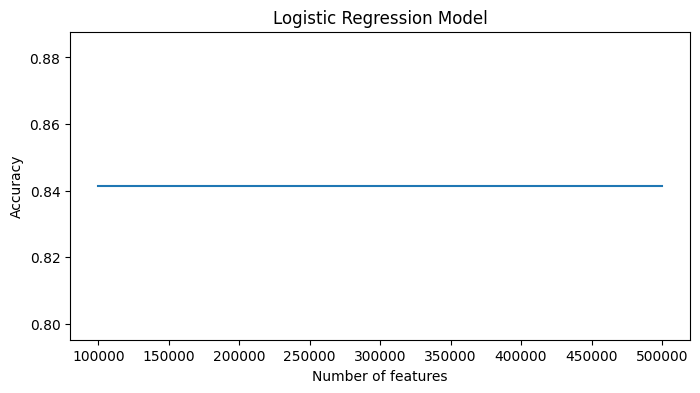

In [53]:
fig = plt.figure(figsize=(8, 4))
plt.plot(logreg_accu.topwords, logreg_accu.accuracy)
plt.xlabel("Number of features")
plt.ylabel("Accuracy")
plt.title("Logistic Regression Model")
plt.show()

# **Part 2 - Creating a Neural Network based on the BERT encoder**

Now we are done with the sentiment analysis using logic regression. next step is using a neural network using tensorflow and BERT pre-trained model to analyze data. libraries used:

In [ ]:
import pandas as pd
from os.path import join
#!pip install tensorflow_text
from collections import Counter
import h5py
from nltk.stem import WordNetLemmatizer
import gensim.parsing.preprocessing as gprep
import gensim.utils as gutil
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import keras.utils
from sklearn import metrics

our new sampled dataframe, but this time we want to use star rating as our main objective to classify the reviews, because it is easier to work with numerical data in neural networks.

# Making the dataset

In [ ]:
review_df["star_rating"].value_counts()
data = df[['star_rating', 'review_body']]
sample2 = data.groupby("star_rating").sample(500)
sample2["review_body"] = sample2["review_body"].apply(str)
sample2

like the previous part, we need to lemmatize and tokenize our sample. this time we are using gensim lib besides nltk lemmatizer to do this.

# Preprocessing

In [ ]:
def preprocess(text):
    preprocs = [
        gprep.strip_tags,
        gprep.strip_punctuation,
        gprep.strip_multiple_whitespaces,
        gprep.strip_numeric,
        gprep.remove_stopwords,
        gprep.strip_short,
    ]
    text = gutil.to_unicode(text.lower().strip())
    for preproc in preprocs:
        text = preproc(text)
    return text
def lemmatize(text):
    wnl = WordNetLemmatizer()
    return wnl.lemmatize(text)

preprocessing our sample:

In [ ]:
sample2["review_body"] = sample2["review_body"].apply(preprocess)
sample2

importing bert module:

# Importing BERT module and building the neural network:

In [ ]:
bert_preprocess = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')
bert = hub.KerasLayer('https://tfhub.dev/google/experts/bert/wiki_books/sst2/2')

adding a two layer classifier and adding L2 weight regularization to get a better accuracy.

In [ ]:
def build_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='txt_input')
    bert_input = bert_preprocess(text_input)
    bert_output = bert(bert_input)
    clf_input = bert_output['pooled_output']
    clf = tf.keras.layers.Dropout(0.1)(clf_input)
    clf = tf.keras.layers.Dense(384, activation='sigmoid', kernel_regularizer='l2')(clf)
    clf = tf.keras.layers.Dropout(0.1)(clf)
    clf = tf.keras.layers.Dense(5, activation='sigmoid', name='clf')(clf)
    return tf.keras.Model(text_input, clf)

model = build_model()
model.summary()

using predefined functions for the bert transfer learning module to use on our dataset.

# Training and testing the dataset

In [ ]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = [tf.metrics.SparseCategoricalAccuracy()]
optimizer = tf.keras.optimizers.Adam()
model.compile(loss = loss, optimizer = optimizer, metrics = metrics)

making our train, test and validation set:

In [ ]:
x_data = sample2['review_body'].to_numpy()
y_data = sample2['star_rating'].to_numpy() - 1

x_train, x_rest, y_train, y_rest = train_test_split(x_data, y_data, test_size = 0.4, stratify=y_data, random_state = 42)
x_val, x_test, y_val, y_test = train_test_split(x_rest, y_rest, test_size = 0.5, stratify=y_rest, random_state = 42)
#checking the proportion just in case: 60 20 20
print(f"x_train: {x_train.shape} | x_val: {x_val.shape} | x_test: {x_test.shape} | \n" +
    f"y_train: {y_train.shape} | y_val: {y_val.shape} | y_test: {y_test.shape} | ")

starting the training process on our dataset. epoch value is 3 to speed up processing. value should be 10 for better accuracy.

In [ ]:
history = model.fit(x_train, y_train, epochs=3, batch_size=10, validation_data=(x_val, y_val))

saving our model:

In [ ]:
model.save("model_1.h5")
model = tf.keras.models.load_model(("model_1.h5"), custom_objects={'KerasLayer':hub.KerasLayer})
model

testing our new model to predict our test values:

In [ ]:
predict = model.evaluate(x_test, y_test)
print("[loss, accuracy]:", predict)

TODO: create a function to vectorize any input sentence and predict using bert NN model.

In [ ]:
sentence = "I really love this watch."
#model.predict(sentence)

making a plot for accuracy:

In [ ]:
plt.figure(figsize=(8,4))
plt.title("Model accuracy")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.show()

## **Part 3 - Comparison**

now we compare the accuracy of both models for reference:

In [ ]:
plt.figure(figsize=(8,4))
plt.title("Model accuracy")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.plot(logreg_accu.accuracy, color='r', label = 'logistic regression')
plt.plot(history.history['val_sparse_categorical_accuracy'], label = 'bert NN')
plt.legend()
plt.show()

the plot shows logistic regression to have a better accuracy, but since the number of samples, epochs and traning dataset for bert NN model is less than the values for logreg model, therefore this execution may not be accurate.